# Machine Learning for Many-Body Physics, Tutorial 1: 
# Learning the Ising Hamiltonian using linear regression

Perimeter Scholars International 2022-2023

February 28, 2023

Lauren Hayward

**References:** Section VI.D of https://arxiv.org/abs/1803.08823, and the corresponding Notebook D from https://physics.bu.edu/~pankajm/MLnotebooks.html

## Generate the data set:

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import linear_model
%matplotlib inline

#np.random.seed(2023)

N = 40   #number of spins
M = 10000  #number of samples 
J = 1.0  #coupling energy for generating the data

#Randomly generate the spin configurations
s = np.random.choice([-1,1], size=(M,N))

def getEnergy_nnIsing1D(s):
#     EnSet = []
#     for i in range(M):
#         E = 0
#         for j in range(N):
#             E+=s[i][j]*s[i][(j+1)%N]
#         EnSet.append(E)
#     return EnSet
    return np.sum(-s*np.roll(s,-1),axis=1)

H = getEnergy_nnIsing1D(s) #Labels for each configuration

# Introduce the variable x as in part b: s_j*s_k --> x_p
x = np.einsum('ij,ik->ijk',s,s) 

#Consider only the upper triangular part of this matrix since we only want to consider k>j:
iu = np.triu_indices(x.shape[1],k=1)
x = x[:,iu[0],iu[1]]



a) I would expect that if $H_{\text {model }}(\vec{s})=H_{\text {data }}(\vec{s})$ for all $\vec{s}$ then the coupling parameters should be $J_{j j+1} = 1$ and $J_{j k} = 0$ otherwise. This is because the data is generated from only nearest neighbour interactions with coupling 1. 

b) We start with the model Hamiltonian $H_{\text {model }}=-\sum_{j=1}^N \sum_{k>j} J_{j k} s_j s_k$ 

## Define a function to plot the coupling parameters $J_{jk}$

In [60]:
def plot_J(w,N):
    J = np.zeros((N,N))

    #Fill in the upper triangular part with entries from w:
    iu = np.triu_indices(N,k=1)
    J[iu] = -1.0*w

    #Plot this matrix:
    max_Jmag = max(np.max(J),-1*np.min(J))
    cmap_args=dict(vmin=min(-1.,-1*max_Jmag), vmax=max(1.,max_Jmag), cmap='PRGn')

    fig, ax = plt.subplots() 
    im      = ax.imshow(J,**cmap_args)
    ax.set_title(r'$J_{jk}$',fontsize=18)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar=fig.colorbar(im, cax=cax)

    plt.show()
    

## Find the parameters $J_{jk}$ using the exact solution

$\vec{w}_{\text {exact }}=\left(X^T X\right)^{-1} X^T \vec{y}$

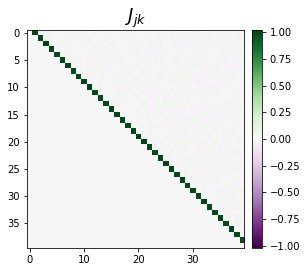

CPU times: user 6.19 s, sys: 819 ms, total: 7.01 s
Wall time: 5.26 s


In [61]:
%%time
w_exact = np.linalg.inv(x.T.dot(x)).dot(x.T).dot(H)

# np.zeros(x.shape[1]) 
plot_J(w_exact,N)

f) I see an error "LinAlgError: Singular matrix". This will probably be due to the fact that x is no longer invertable for some reason. If I change M to 40 then the exact solver works fine. Thus for the exact solver to work we need M >= N.

## Find the parameters $J_{jk}$ using gradient descent

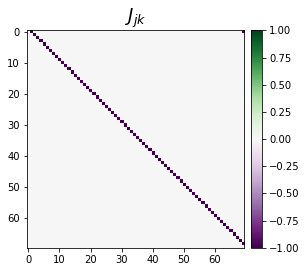

CPU times: user 1.38 s, sys: 138 ms, total: 1.52 s
Wall time: 1.34 s


In [55]:
%%time
w_init = 2*np.random.rand(x.shape[1])-1 #initialize the w parameters randomly

#Apply gradient descent with a constant learning rate of eta0:
w_GD = linear_model.SGDRegressor(penalty=None, learning_rate='constant', eta0=0.0001).fit(x, H, coef_init=w_init).coef_
plot_J(w_GD,N)

g) 
eta0=0.001 - Initial eta

eta0=0.005 - nothing much changes

eta0=0.03 - Too large of a learning rate, the algorithm is unable to find that the coupling is only between nearest neighbours and instead finds large coupling between many different spins far apart. 

eta0=0.000003 - Took the maximum number of steps before it reached convergence. Too small of steps.

eta0=0.00003 - can see faint errors in the non neighbour interactions but very small fluctuations. 

h)

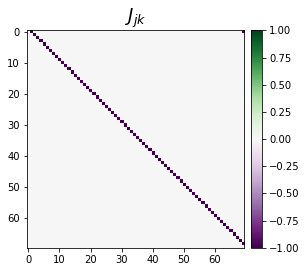

CPU times: user 23.7 s, sys: 10.9 s, total: 34.6 s
Wall time: 5.48 s


In [53]:
%%time
w_exact = linear_model.LinearRegression().fit(x, H).coef_

# np.zeros(x.shape[1]) 
plot_J(w_exact,N)

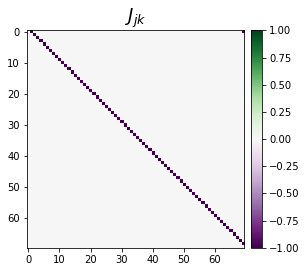

CPU times: user 1.62 s, sys: 283 ms, total: 1.9 s
Wall time: 1.48 s


In [54]:
%%time
w_init = 2*np.random.rand(x.shape[1])-1 #initialize the w parameters randomly

#Apply gradient descent with a constant learning rate of eta0:
w_GD = linear_model.SGDRegressor().fit(x, H, coef_init=w_init).coef_
plot_J(w_GD,N)

i) For M = 10000 and N = 70 we find that the gradient decent algorithm runs around 